## FDW Crop Production Data Profiling - Zambia

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735' 
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/ZM_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Zambia',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	|
| 2011	 | ZM2011A1 | 10	| ZM2011A2	| 74	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'


#2. Manual setting
# a) population groups within admin units
# Zambia has a number of admin 2 units with population groups that split the admin into two, 
# (e.g. ~Lusaka Rural East~ and ~Lusaka Rural West~). These two groups need to be recombined to map because
# there is no regional shapefile definition for these sub-admin units (for some countries there is)
#
# Calculate the sum of production, harvested area and planted area, then recalculate yield for these admin units
rows = ['fnid','season_year', 'product','indicator','crop_production_system','value','population_group']
#find duplicates then aggregate to fnid after pivoting around the indicator
dupes = df[rows[:-1]][df[rows[:-2]].duplicated(keep=False)]
#create a df that has one value per duplicated value
toFill = df[df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]# find all duplicates
toFill = toFill[~toFill[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep='first')]# keep only one
dupes = dupes.groupby(by=['fnid','season_year','indicator','crop_production_system','product']).sum()
dupes.reset_index(inplace=True)
d_ha = dupes.copy(deep=True)
d_pa = dupes.copy(deep=True)
d_ha['value'].loc[dupes.indicator=='Yield'] = d_ha['value'].loc[d_ha.indicator=='Quantity Produced'].values/\
                                               d_ha['value'].loc[d_ha.indicator=='Area Harvested'].values
#if calculated yield is nan (meaning HA = 0), recalculate w/ planted area
d_pa['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[d_pa.indicator=='Quantity Produced'].values/\
                                               d_pa['value'].loc[d_pa.indicator=='Area Planted'].values
#For Zambia the planted area seems to be more reliable, so let's use planted area consistently rather than harvested area
dupes['value'].loc[dupes.indicator=='Yield'] = d_pa['value'].loc[dupes.indicator=='Yield']
#find where calculated yield is nan when calculated with PA and use HA instead
dupes['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))] = \
      d_ha['value'].loc[(dupes.indicator=='Yield')&(~np.isfinite(dupes.value))]
#set 0 back to nan
dupes['value'].loc[dupes.value==0]=np.nan
#merge the new values back into the placeholder DF
toFill = toFill.drop(['value'],axis=1)
toFill = toFill.merge(dupes, how='left',on = ['fnid','season_year','indicator','crop_production_system','product'])
#drop all duplicate obs from original DF and append the filled DF
df = df[~df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]
df = df.append(toFill)
#becasue the population groups have been recombined, set them all equal to 'none'
df['population_group'] = 'none'

#3) limit to areas with collected data
df = df[df['status'] == 'Collected']

#4) Rename the unspecified variety of Millet to be the same crop as Millet (Finger) in 2011, 
#then drop the 2015 and 2016 obs b/c they're not the same crop
df = df[~((df['product']=='Millet (Finger)')&
              ((df.season_year=='Annual 2015')|(df.season_year=='Annual 2016')))]
df['product'][df['product']=='Millet (Finger)'] = 'Millet'

#5) remove a couple of incorrect values (off by multiple orders of magnitude) that couldn't be corrected
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A20908')&(df.season_year=='Annual 2001')]=np.nan
df['value'][(df['product']=='Sorghum')&(df.fnid=='ZM1998A21207')&(df.season_year=='Annual 1998')]=np.nan

#6) fix one value, which is off by an order of magnitude according to the recorded yield value
df['value'][(df['indicator']=='Area Harvested')&(df['product']=='Rice (Paddy)')
   &(df.fnid=='ZM1998A20410')&(df.season_year=='Annual 2008')] = 40

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df,area_default='planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ZM_Admin2_1980,ZM_Admin2_1998,ZM_Admin2_2011], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

/var/folders/pk/_ym78shs7tx06w00zbcwxwgc0000gp/T/ipykernel_23852/2338460088.py:30: RuntimeWarning: divide by zero encountered in true_divide
  d_ha['value'].loc[dupes.indicator=='Yield'] = d_ha['value'].loc[d_ha.indicator=='Quantity Produced'].values/\


- Remove missing records ---------------------- #
Orignial data points: 20,828
Removed 200 "Missing Value" points
3,654/3,685 "Area Harvested" points are retained.
5,699/5,725 "Area Planted" points are retained.
5,638/5,709 "Quantity Produced" points are retained.
5,637/5,709 "Yield" points are retained.
Current data points: 20,628

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1980 - 2017
8 grain types are found: Barley (Unspecified), Maize (Corn), Maize Grain (White), Maize Grain (Yellow), Millet, Rice (Paddy), Sorghum, Wheat Grain
1 seasons are found: Annual (04-01)
1 crop production system are found: none
Data sources include:
[1] Ministry of Agriculture and The Central Statistics Office, Zambia --- Crop Forecast Survey Results, Zambia
[2] Ministry of Agriculture and The Central Statistics Office, Zambia --- FEWS NET Agro Maps, Zambia
Administrative-1 fnids: 0
Administrative-2 fnids: 202
0 reporting units are found

## Zambia
Zambia crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-zambia.png?itok=iCbUXJ29)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_za_calendar.png)

- comparison of boundaries
![image](./figures/ZM_admin_shapes.png)

- In Zambia, basd on the FEWS NET data, there were four times of changes in administrative units: 1980, 1998, 2011, and 2012.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1980	 | ZM1980A1 | 9	| ZM1980A2	| 57	|
| 1990	 | ZM1990A1 | 9	| nan	| 0	|
| 1998	 | nan | 0	| ZM1998A2	| 72	|
| 2011	 | ZM2011A1 | 10	| ZM2011A2	| 74	|
| 2012	 | ZM2012A1 | 10	| ZM2012A2	| 89	|


- Here, we use **`ZM2011A2`** to represent all admin-level 2 crop data because although there is a 2012 file, this doesn't appear to be used (e.g. no corresponding FNIDs)
- The data is all reported as `Annual` for the season
- Original data have both 'none' and 'all' as production systems, but these are essentially the same, indicating a default produciton system so they have all been changed to 'none' types.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = ZM_Admin2_2011.copy().to_crs('epsg:32735')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
#shape_used['ADMIN2'] = 'None'
#shape_all['ADMIN2'] = 'None'
#shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
# - Aggregate grain data by grain type
#FlagGrainType = True
#[area, prod, area_all, prod_all] = FDW_PD_GrainTypeAgg([area, prod, area_all, prod_all], product_category)
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

ZM1998A21208:	"Mpulungu" (FDW) is changed to "Chinsali" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_1998, over_1998 = FDW_PD_CreateAdminLink(ZM_Admin2_1998, ZM_Admin2_2011, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1980, over_1980 = FDW_PD_CreateAdminLink(ZM_Admin2_1980, ZM_Admin2_2011, 'ADMIN2', 'ADMIN2', prod, epsg)
# Crop specific ratios
link_ratio_1998 = FDW_PD_RatioAdminLink(link_1998, prod, over_1998, mdx_pss)
link_ratio_1980 = FDW_PD_RatioAdminLink(link_1980, prod, over_1980, mdx_pss)

# Merge link_ratio
assert link_ratio_1998.keys() == link_ratio_1980.keys()

link_merged = [link_ratio_1980, link_ratio_1998]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)

# No calibration of Growing and Harvest year and season is needed
cs = {
    'Annual': {'growing_month':{'04-01':'04-01'},'harvest_month':{'07-01':'07-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_ZM.hdf', stack)
save_hdf('./data/crop/adm_crop_production_ZM_raw.hdf', df)
save_npz('./data/crop/adm_crop_production_ZM_ratio.npz', link_ratio)

./data/crop/adm_crop_production_ZM.hdf is saved.
./data/crop/adm_crop_production_ZM_raw.hdf is saved.
./data/crop/adm_crop_production_ZM_ratio.npz is saved.


## Visualization of production data

./figures/ZM_bar_natgrainprod_Annual.png is saved.


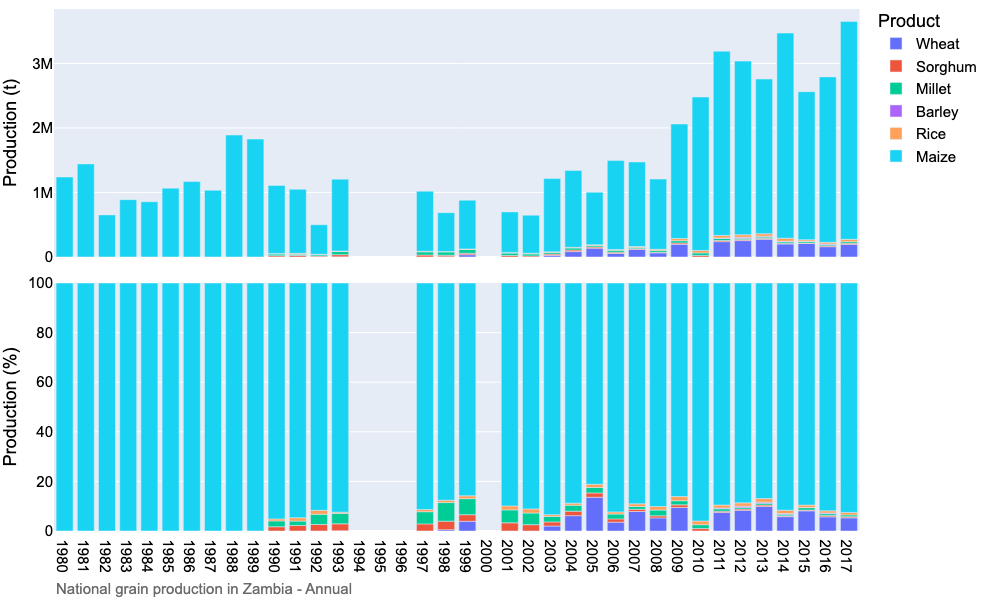

In [7]:
# Bar chart of national grain production
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Wheat', 'Sorghum', 'Millet','Barley',  'Rice','Maize']
for season_name in ['Annual']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

./figures/ZM_line_pay_Barley_Annual.png is saved.


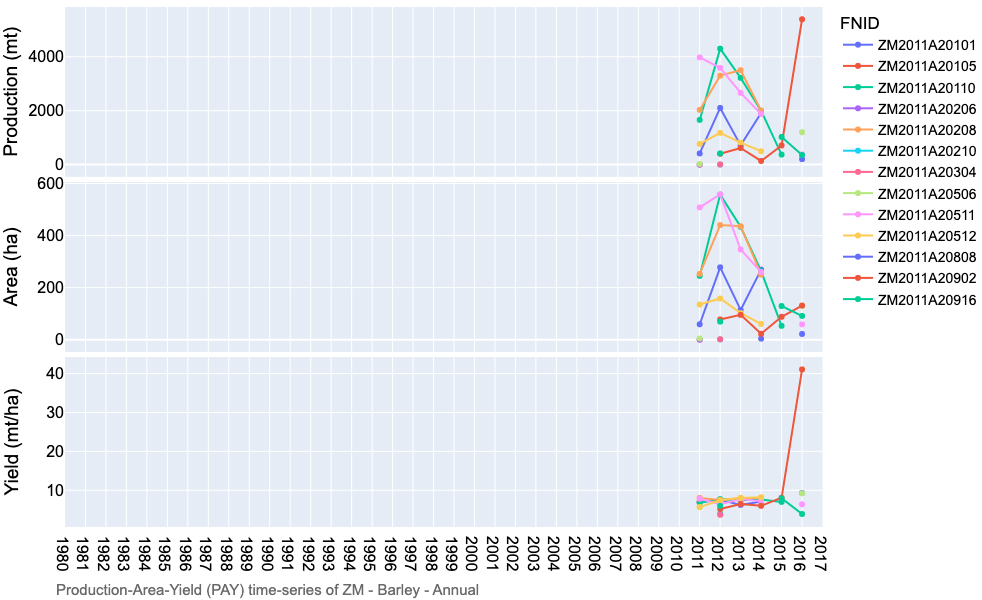

./figures/ZM_line_pay_Maize_Annual.png is saved.


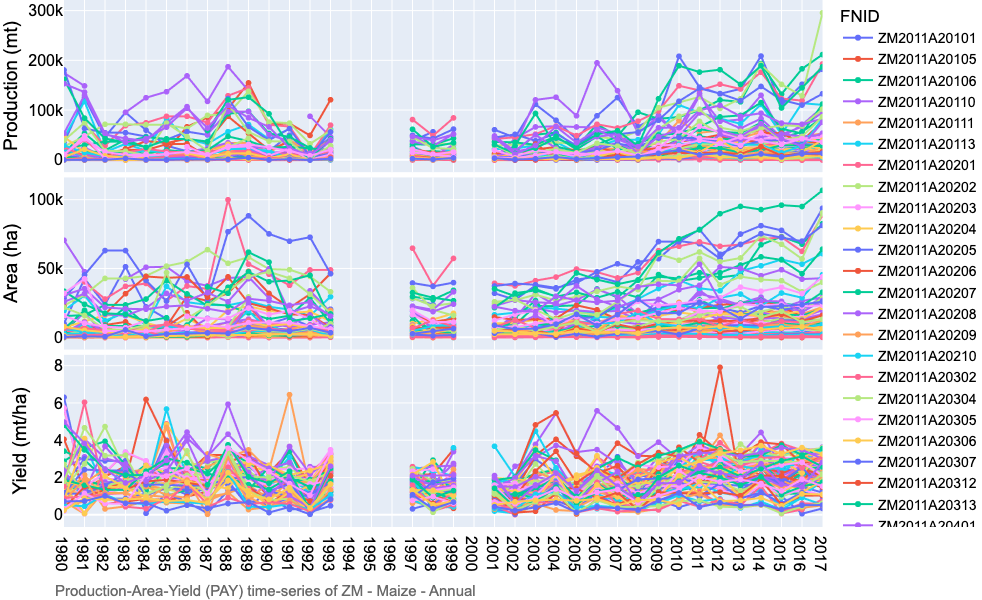

./figures/ZM_line_pay_Millet_Annual.png is saved.


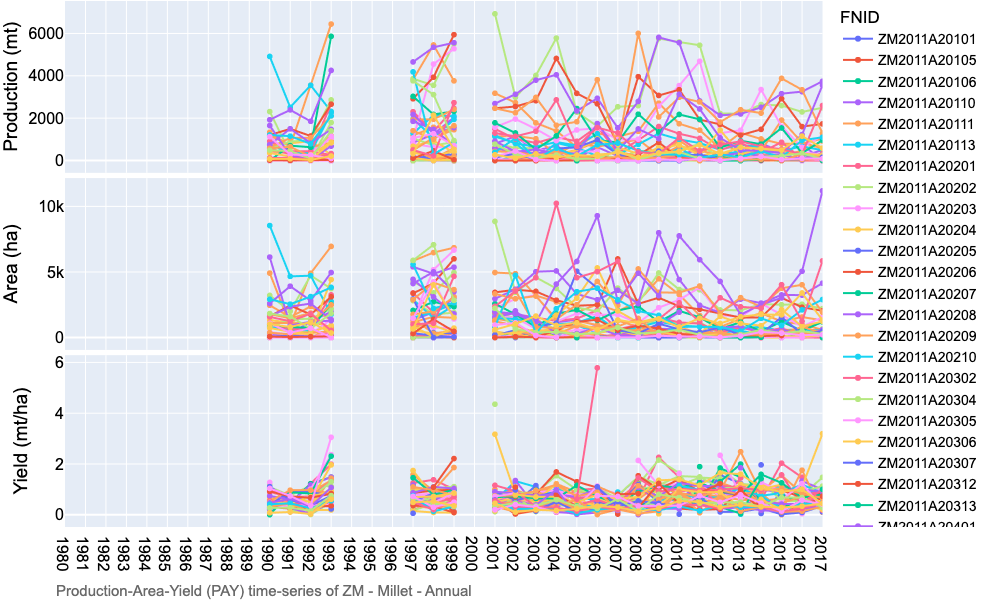

./figures/ZM_line_pay_Rice_Annual.png is saved.


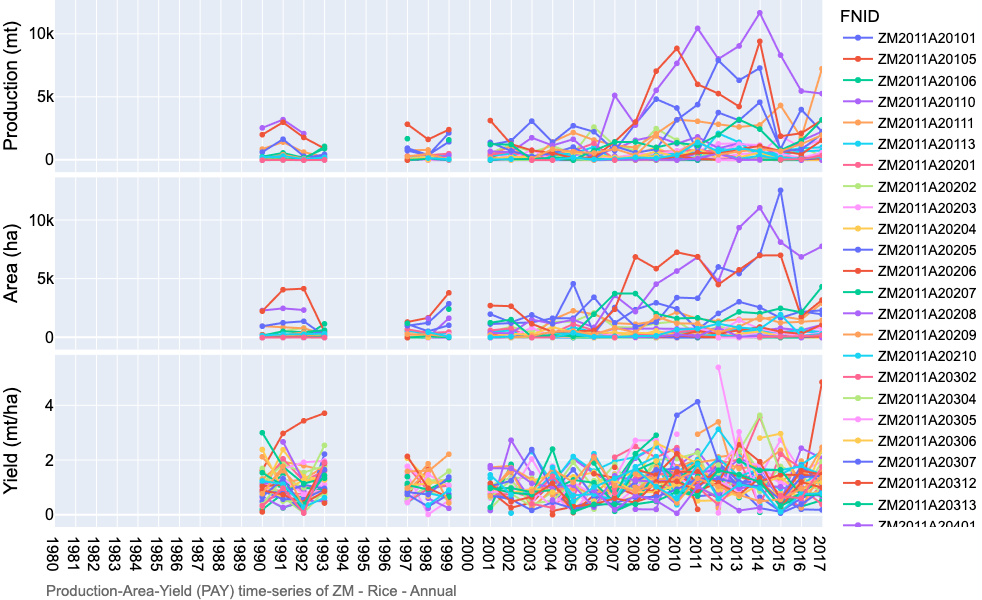

./figures/ZM_line_pay_Sorghum_Annual.png is saved.


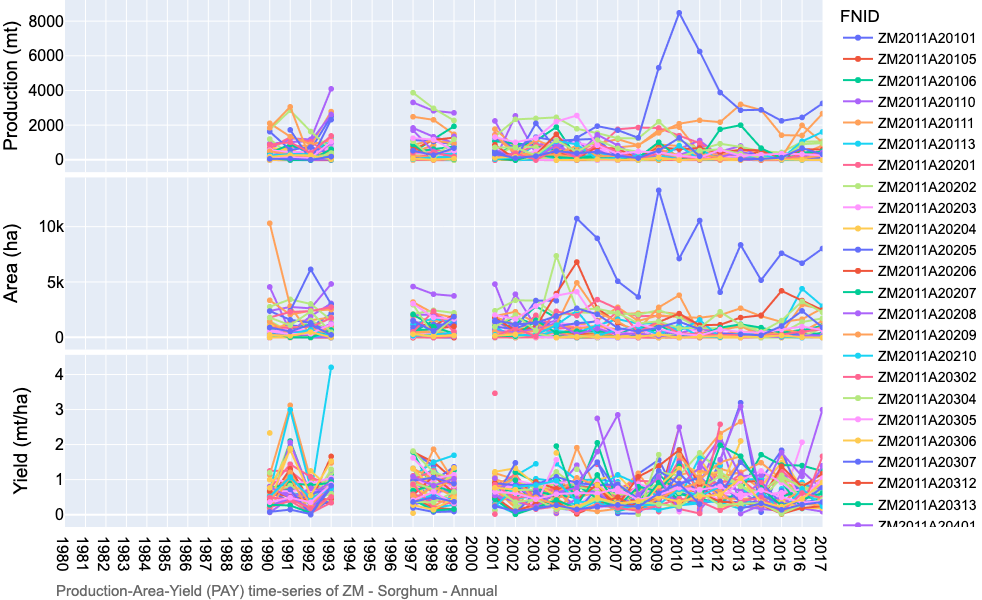

./figures/ZM_line_pay_Wheat_Annual.png is saved.


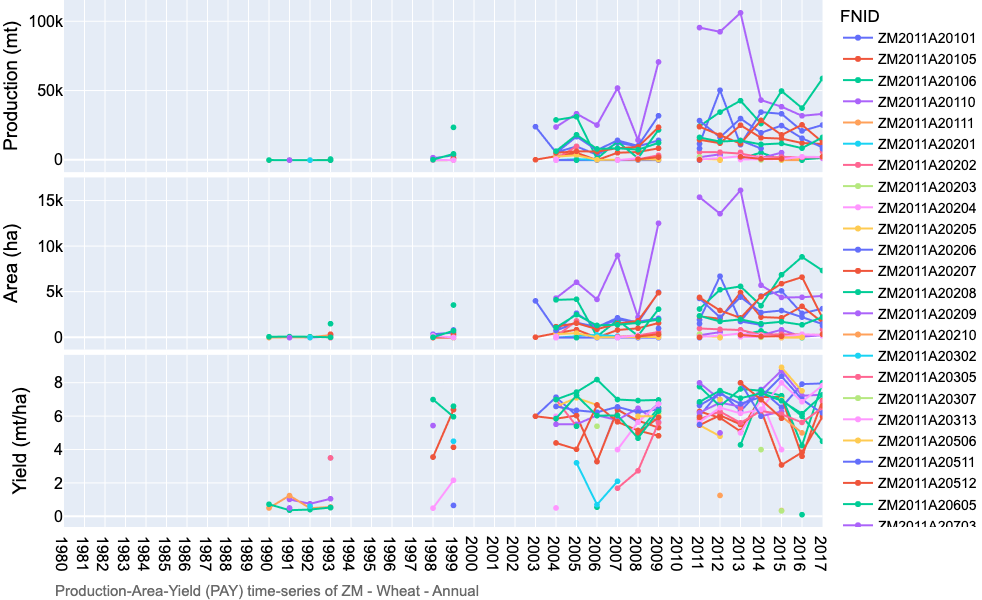

In [8]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Barley', 'Annual'],
    ['Maize', 'Annual'],
    ['Millet', 'Annual'],
    ['Rice', 'Annual'],
    ['Sorghum', 'Annual'],
    ['Wheat', 'Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [9]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'ZM', 'Zambia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Barley', 'Annual'],
    ['Maize', 'Annual'],
    ['Millet', 'Annual'],
    ['Rice', 'Annual'],
    ['Sorghum', 'Annual'],
    ['Wheat', 'Annual'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)

./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20101.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20105.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20110.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20206.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20208.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20506.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20511.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20512.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20902.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20916.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20210.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20304.png is saved.
./figures/crop_calibrated/ZM_Barley_Annual_ZM2011A20808.png is saved.
./figures/crop_calibrated/ZM_Maize_Annual_ZM2011A20101.png is saved.
./figures/crop_calibr